In [92]:
from ase.build import bulk
from ase.optimize import GPMin
from ase.calculators.emt import EMT
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [93]:
# Build a silver (Ag) unit cell

ag = bulk("Ag", "fcc", cubic=True)
view(ag, viewer="x3d")

In [94]:
calc = EMT()    # Attach calculator to Ag unit cell
ag.calc = calc
opt = GPMin(ag)
opt.run(fmax=.05)   #Optimize the system


       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000


True

In [95]:
cell = ag.cell
print(cell.lengths())   # Retrieve lattice constant and unit cell volume
print(cell.volume)


[4.09 4.09 4.09]
68.417929


The optimized lattice constant: 4.09 Å

Equilibrium cell volume: 68.42 Å<sup>3

In [96]:
v0 = cell.volume
volume_range = np.arange(0.8 * v0, 1.2 * v0, .02 * v0)  # Create range of volumes

In [97]:
# Relax the atomic positions of Ag unit cells w/ different volumes

potential_energies = [] # Initialize lists to store potential energies, lattice constants, and volumes
lengths = []
volumes = []

for vol in volume_range:
    lattice_const = np.cbrt(vol)
    new_ag = bulk("Ag", "fcc", a=lattice_const, cubic=True)
    new_ag.calc = calc
    opt.run(fmax=.05)
    new_ag_cell = new_ag.cell
    potential = new_ag.get_potential_energy()
    lengths.append([new_ag_cell.lengths()])
    potential_energies.append(potential)
    volumes.append(new_ag_cell.volume)

       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 18:45:02        0.006337        0.000000
       Step     Time          Energy          fmax
GPMin:    0 1

In [98]:
# Verify that volume was fixed during the simulation
test = volume_range - volumes
test

array([ 7.10542736e-15, -2.84217094e-14, -7.10542736e-15,  0.00000000e+00,
        7.10542736e-15,  3.55271368e-14,  2.13162821e-14, -2.84217094e-14,
       -1.42108547e-14,  0.00000000e+00, -1.42108547e-14,  0.00000000e+00,
       -1.42108547e-14, -1.42108547e-14, -5.68434189e-14,  0.00000000e+00,
        0.00000000e+00,  1.42108547e-14,  2.84217094e-14,  0.00000000e+00])

In [99]:
np.where(potential_energies == np.min(potential_energies))
print(f"The potential is minimized at V = {volume_range[9]} A^3")

The potential is minimized at V = 67.04957042 A^3


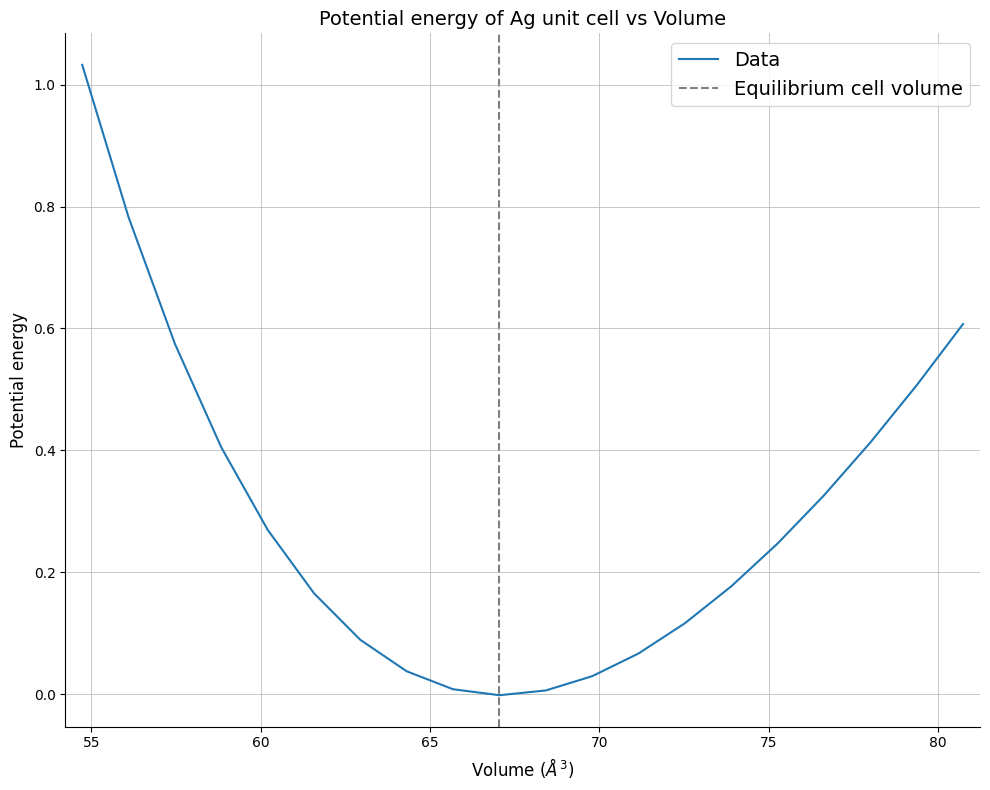

In [100]:
plt.figure(figsize=(10,8))
plt.plot(volume_range, potential_energies, label="Data")
plt.xlabel("Volume ($Å^3$)", fontsize=12)
plt.ylabel("Potential energy", fontsize=12)
plt.title("Potential energy of Ag unit cell vs Volume", fontsize=14)
plt.grid(linewidth=0.5)
plt.xlim(volume_range[0] - 0.5, volume_range[-1] + 0.5)
plt.axvline(67.04957042, linestyle="--", label="Equilibrium cell volume", color="black", alpha=0.5, zorder=1)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("Ag_U_vs_V.png")

In [101]:
# Define the Murnaghan EOS

def murnaghan(V, k0, k0_prime, ref_volume=v0):
    """
    The Murnaghan equation of state

    Parameters:
        v: float or int
            Volume of the solid under compression
        k0: float or int
            Bulk modulus at the reference volume
        k0_prime: float or int
            Derivative of the modulus with respect to pressure while temperature and moles
            are held constant
        ref_volume: float or int
            Reference volume
    Returns:
        P: float or int
            Pressure of the solid
    
    
    """
    coeff = k0 / k0_prime
    return coeff * (((V/ref_volume) ** -k0_prime) - 1)

In [102]:
# Extract K0 and K0'


parameters, covariance = curve_fit(murnaghan, volume_range, potential_energies, p0=[50,50])
print(f"K0: {parameters[0]:.3}")
print(f"K0': {parameters[1]:.3}")

K0: 0.324
K0': 18.9


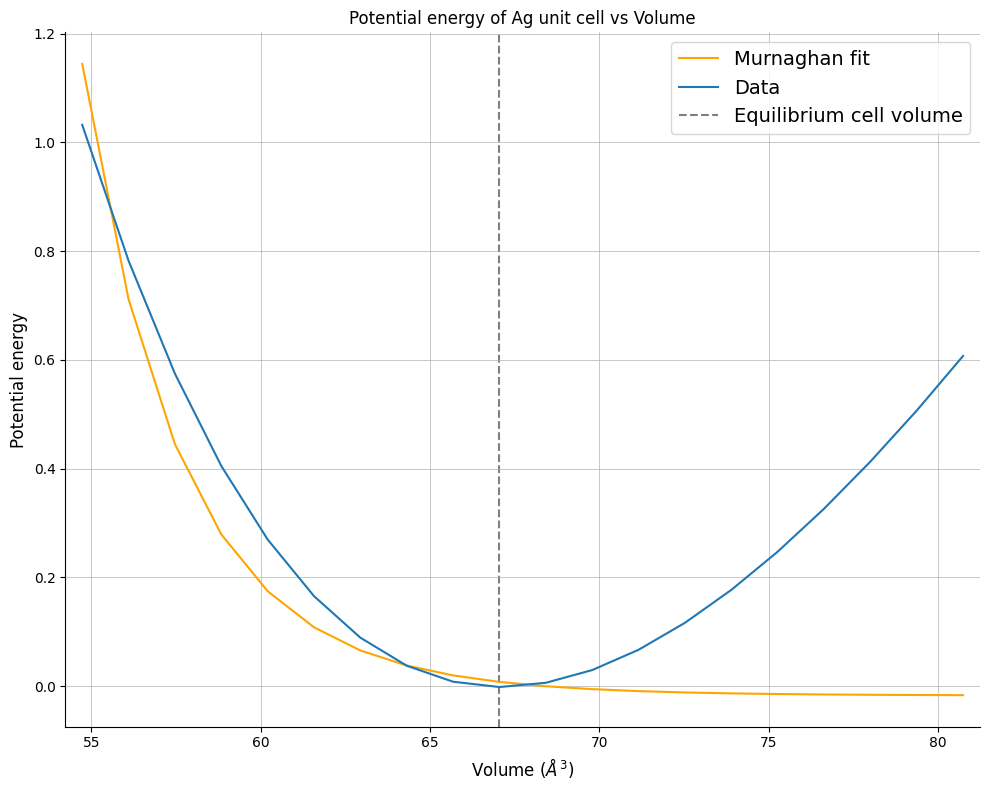

In [107]:

plt.figure(figsize=(10,8))
plt.plot(volume_range, murnaghan(volume_range, parameters[0], parameters[1]), label="Murnaghan fit", color="orange")
plt.plot(volume_range, potential_energies, label="Data", color="#1f77b4")
plt.xlabel("Volume ($Å^3$)", fontsize=12)
plt.ylabel("Potential energy", fontsize=12)
plt.xlim(volume_range[0] - 0.5, volume_range[-1] + 0.5)
plt.title("Potential energy of Ag unit cell vs Volume", fontsize=12)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.grid(linewidth=0.5)
plt.axvline(67.04957042, linestyle="--", label="Equilibrium cell volume", color="black", alpha=0.5, zorder=1)
plt.legend(fontsize=14)
plt.savefig("Fit_Ag_U_vs_V.png")
plt.tight_layout()
plt.show()

The bulk modulus of silver (Ag) reported in the literature is 100. The bulk modulus of silver that was calculated in this problem is 0.324.

In [108]:
standard_error = np.sqrt(np.diag(covariance))
print(f"The fitted K0 is {parameters[0]:.3} with a standard error of {standard_error[0]:.3}")
print(f"The fitted K0' is {parameters[1]:.3} with a standard error of {standard_error[1]:.3}")

The fitted K0 is 0.324 with a standard error of 0.397
The fitted K0' is 18.9 with a standard error of 7.61


The standard error of the bulk modulus is larger than the value obtained for the bulk modulus using the Murnaghan equation as a fit. Furthermore, the standard error of the derivative of the bulk modulus with respect to pressure is nearly one-half than the fitted parameter. 

The plot of the data and the fitted equation shows that this discrepency is the result of the fit deviating from the data at volumes greater than 68.4 Å<sup>3</sup>, the equilibrium cell volume. At volumes larger than the equilibrium cell volume, the Murnaghan equation underestimates the potential energy of the Ag unit cell. Additionally, the plot shows that the underestimation continues to increase at larger volumes. 

However, at volumes shorter than the equilibrium cell volume, the Murhnaghan equation fits th data quite well. Additionally, the plot shows that at volumes less than 56.1 Å<sup>3</sup>, the Murnaghan overestimates the data.